# Olist's Metric Design 

In this challenge, we are going to catch a first glimpse into `Olist's business health`

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data
from olist.data import Olist
data = Olist().get_data()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])


## Test your import!

In [7]:
from nbresult import ChallengeResult

result = ChallengeResult('orders',
    keys_len=len(data),
    key_names=sorted(list(data.keys())),
    reviews_number=len(data['order_reviews'])
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/victoriadorosenco/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/victoriadorosenco/code/victometer/04-Decision-Science/01-Project-Setup/data-optional-metric-design/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 3 items

test_orders.py::TestOrders::test_key_names PASSED                        [ 33%]
test_orders.py::TestOrders::test_keys_len PASSED                         [ 66%]
test_orders.py::TestOrders::test_reviews_number PASSED                   [100%]

============================== 3 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/orders.pickle

git commit -m 'Completed orders step'

git push origin master



## 1 - Orders vs. Reviews?

❓Plot a histogram of `review_score`. 

In [5]:
# data['order_reviews'].head()

<AxesSubplot:xlabel='review_score', ylabel='Count'>

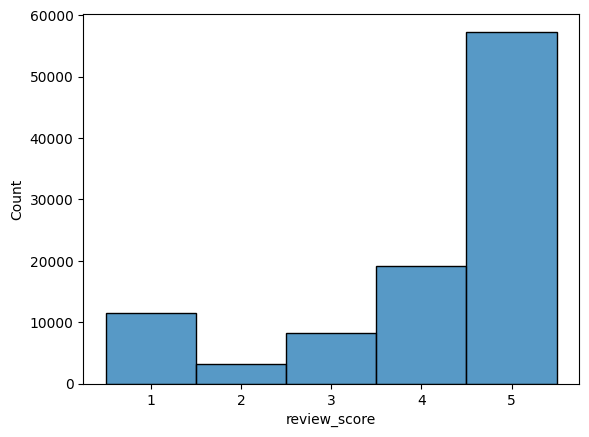

In [7]:
# YOUR CODE HERE
sns.histplot(data=data['order_reviews'], x='review_score', discrete=True)

❓ Plot a histogram of `order_status` <br/>

In [10]:
data['orders']['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

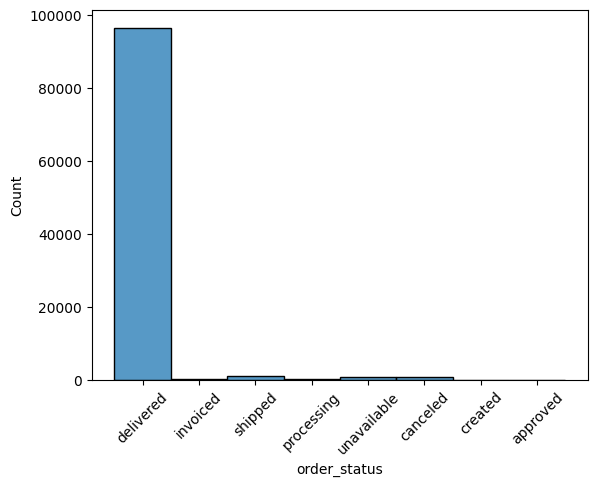

In [14]:
# YOUR CODE HERE
# plt.figure(figsize=(10, 6))
sns.histplot(data=data['orders'], x='order_status', discrete=True)
plt.xticks(rotation=45)

❓ How many of them are delivered ? shipped ? canceled ? ...

In [18]:
# YOUR CODE HERE
data['orders'].groupby(['order_status'])['order_id'].count()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
Name: order_id, dtype: int64

💡 We already know - from our data schema - that each `review` has a unique `order`.

🤔 Do all `orders` have a `review`?

<details>
    <summary><i>▸ Hint</i></summary>

You can use `pd.Series.isna().sum()` to count the number of NaN values in a series
</details>

In [27]:
# YOUR CODE HERE
order_reviews = pd.merge(data['orders'], data['order_reviews'], on='order_id', how='left')
# order_reviews
order_reviews.isna().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                  161
order_delivered_carrier_date      1793
order_delivered_customer_date     2987
order_estimated_delivery_date        0
review_id                          768
review_score                       768
review_comment_title             88424
review_comment_message           59015
review_creation_date               768
review_answer_timestamp            768
dtype: int64

If some orders were not reviewed, count and group them per `order_status`.

In [31]:
# YOUR CODE HERE
order_reviews.groupby(['order_status'])['review_id'].count()

order_status
approved           2
canceled         609
created            3
delivered      96361
invoiced         313
processing       296
shipped         1043
unavailable      597
Name: review_id, dtype: int64

## 2 - Evolution of key business metrics over the past 14 months

## Metrics 

1. Which metric would you use as a `key business output metric`for Olist  📈 ? 
2.  Which metric would you use to measure that a customer had a `good experience with Olist` 🙂 ? 
3. Which metric would you use to measure `shipping delay` 🕗?

For each metric, plot a trend line over time.

### Metric 1: Order numbers

❓ Plot the weekly number of total orders per week (to check how business is going)  


/var/folders/21/9kmsq70n1w1397w8sq08bq8r0000gn/T/ipykernel_98563/3700505349.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['orders']['week'] = data['orders']['order_purchase_timestamp'].dt.week


<AxesSubplot:xlabel='week', ylabel='order_count'>

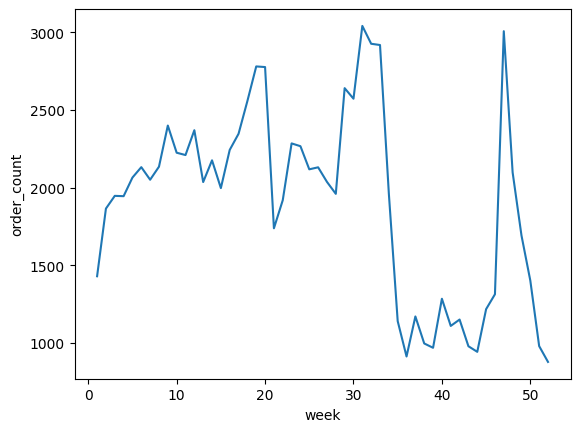

In [48]:
# YOUR CODE HERE
# 1. convert date to pandas date_time
data['orders']['order_purchase_timestamp'] = pd.to_datetime(data['orders']['order_purchase_timestamp'])
# 2. convert date_time to weeks and make a new column
data['orders']['week'] = data['orders']['order_purchase_timestamp'].dt.week
# 3. sort by week
df = data['orders'].sort_values(by='week')
# 4. group by week, count orders
orders_per_week = df.groupby(['week'])['order_id'].count().reset_index(name='order_count')

sns.lineplot(data=orders_per_week, x='week', y='order_count')


❓ Visualize the weekly number of non-delivered orders (to check for any potential issues)

<details>
    <summary><i>▸ Hint </i></summary>    
    
* Convert dates to Python `datetime` objects  
* You can use the built-in `pandas.Series.resample() tool from `pandas` to group your dataset by weeks
    
</details>

<AxesSubplot:xlabel='week', ylabel='undelivered_orders'>

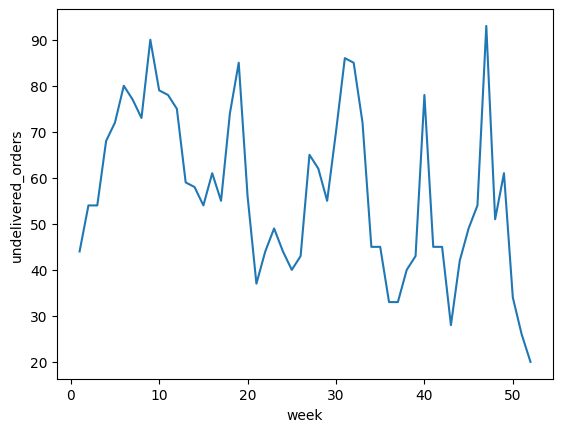

In [63]:
# 1. filter orders df for undelivered only
undelivered_df = data['orders'][data['orders']['order_status'] != 'delivered']
# 2. group by week and count orders
non_delivered = undelivered_df.groupby(['week'])['order_id'].count().reset_index(name='undelivered_orders')

sns.lineplot(data=non_delivered, x='week', y='undelivered_orders')


### Metric 1-bis (optional): Total payment values
❓ After plotting the total number of orders, we could also have a look at the weekly sum of `payment_value` in `BRL` to approximate Olist's weekly revenues.

<AxesSubplot:xlabel='week', ylabel='value (BRL)'>

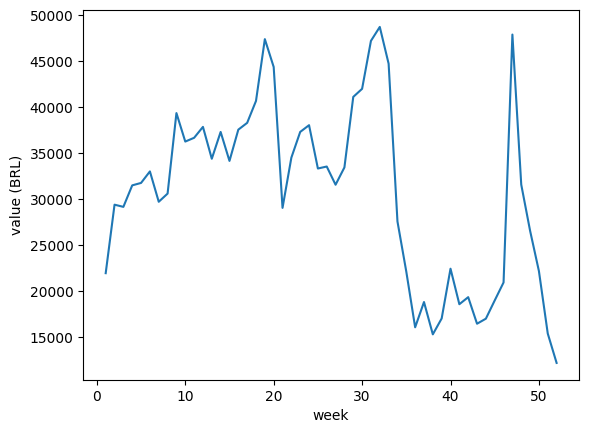

In [78]:
# 1. merge orders with payments
payments_df = data['orders'].merge(data['order_payments'])
# 2. groupby week, sum payment_value
weekly_revenue = (payments_df.groupby(['week'])['payment_value'].sum() * 0.1).reset_index(name='value (BRL)')
# weekly_revenue
sns.lineplot(data=weekly_revenue, x='week', y='value (BRL)')

💡 Merge the `payments` dataset with the `orders` dataset to collect the date of each payment.

In [83]:
# YOUR CODE HERE
payments_df.head()
# 1. convert date column to date only, no hours
payments_df['order_purchase_timestamp'] = pd.to_datetime(payments_df['order_purchase_timestamp']).dt.date
# payments_df['order_purchase_timestamp']
# 2. display selected columns
df_payment_date = payments_df[['order_purchase_timestamp', 'payment_value']]
df_payment_date

,order_purchase_timestamp,payment_value
0,2017-10-02,18.12
1,2017-10-02,2.00
2,2017-10-02,18.59
3,2018-07-24,141.46
4,2018-08-08,179.12
...,...,...
103881,2017-03-09,85.08
103882,2018-02-06,195.00
103883,2017-08-27,271.01
103884,2018-01-08,441.16


⌛️ Once again, do not forget to handle datetimes properly

In [ ]:
# YOUR CODE HERE

📈 Visualize the number of orders and total amount of payments per week

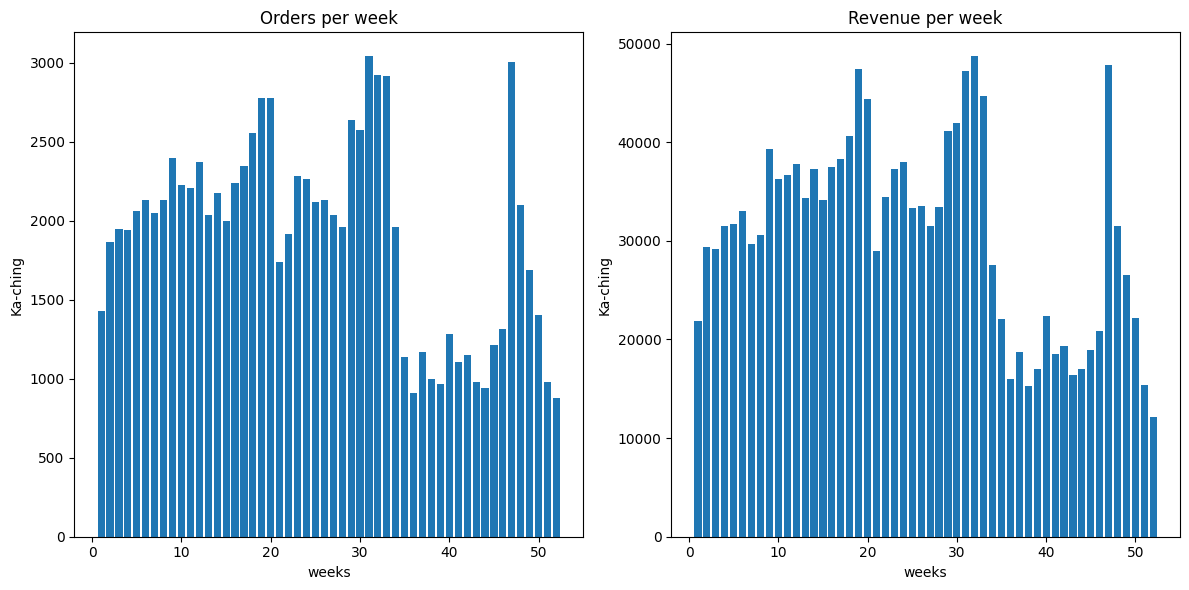

In [96]:
weekly_orders = orders_per_week
weekly_payments = weekly_revenue

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first metric on the first subplot
axs[0].bar(orders_per_week['week'], orders_per_week['order_count'], linestyle='-')
axs[0].set_title('Orders per week')
axs[0].set_xlabel('weeks')
axs[0].set_ylabel('Ka-ching')

# Plot the second metric on the second subplot
axs[1].bar(weekly_revenue['week'], weekly_revenue['value (BRL)'], linestyle='-')
axs[1].set_title('Revenue per week')
axs[1].set_xlabel('weeks')
axs[1].set_ylabel('Ka-ching')

plt.tight_layout()

📈 *(Optional)* Plot the weekly number of orders and payments again with techniques you learned during the `Data Visualization` module :)

In [ ]:
# YOUR CODE HERE

### Metric 2: Customer Satisfaction
❓ How does the `customer satisfaction` evolve on a monthly basis ? Use the mean average `review_score` to illustrate the customer satisfaction.

👉 Load the `reviews` :

In [110]:
data['order_reviews']['review_creation_date'] = pd.to_datetime(data['order_reviews']['review_creation_date']).dt.date
data['order_reviews']['month'] = pd.to_datetime(data['order_reviews']['review_creation_date']).dt.month

# group orders by month
monthly_review_means = data['order_reviews'].groupby(data['order_reviews']['month'])['review_score'].mean().reset_index()

⌛️ If you need to handle datetime, do it.

<AxesSubplot:xlabel='month', ylabel='review_score'>

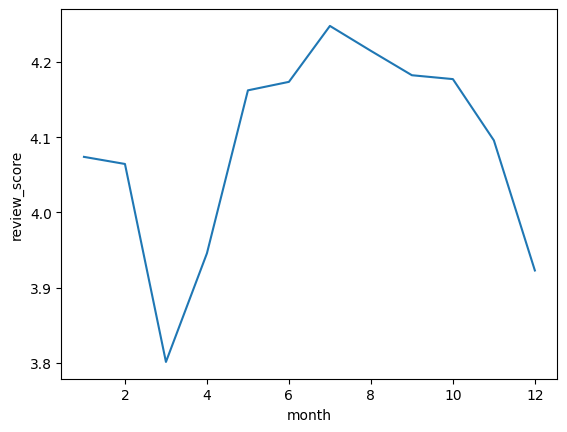

In [111]:
sns.lineplot(data=monthly_review_means, x='month', y='review_score')

📉 Plot the customer satisfaction evolution over time

In [ ]:
# YOUR CODE HERE

📉 *(Optional)* Plot the customer satisfaction evolution over time again with techniques you learned during the Data Visualization module :)

In [ ]:
# YOUR CODE HERE

### Metric 3: Shipping delay

❓Create two new metrics, `delay_vs_expected` and `wait_time` in ***days***, from the `orders` dataset, and plot their historical evolution on a weekly basis to detect trends

<details>
    <summary>▸ <i>Hint</i></summary>

    
Ask `StackOverflow` to help you compute differences between `datetime`s in Python!
</details>

🛒 Let's focus on delivered orders so that we can compute the shipping delays:

In [129]:
data['orders'].head()
# convert req cols into date and apply to all df, i.e. df[['A', 'B']] = df[['A', 'B']].apply(pd.to_datetime)
data['orders'][['order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp']] = data['orders'][['order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp']].apply(pd.to_datetime)

# delay_vs_expected => delivered_customer_date - estimated_delivery_date
data['orders']['delay_vs_expected'] = (data['orders']['order_delivered_customer_date'] - data['orders']['order_estimated_delivery_date']).dt.days

# wait_time =>  delivered_customer_date - purchase_timestamp
data['orders']['wait_time'] = (data['orders']['order_delivered_customer_date'] - data['orders']['order_purchase_timestamp']).dt.days
# delay_vs_expected
data['orders'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,week,delay_vs_expected,wait_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10,2017-10-18,40,-8.0,7.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07,2018-08-13,30,-6.0,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17,2018-09-04,32,-18.0,8.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02,2017-12-15,46,-13.0,13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16,2018-02-26,7,-10.0,2.0


⌛️ Datetime problems again ? Fix them ;)

In [ ]:
# YOUR CODE HERE

👉 Compute the delay between the actual delivery date and the ETA for each order.

In [ ]:
# YOUR CODE HERE

👉 Compute the waiting time between the actual delivery date and the moment a customer ordered their items

In [ ]:
# YOUR CODE HERE

⌛️ How many orders were delivered later than expected ? <br/>
*You can also give an answer in terms of percentage if you prefer.*
<details>
    <summary><i>▸ Hint </i></summary>

    
You can create a `boolean_feature` which is :
* True when actual_delivered_date > ETA $\leftrightarrow$ actual_delivered_date - ETA > 0
* False otherwise
    
</details>




In [142]:
delayed_orders = (data['orders']['delay_vs_expected']>0).sum()
percentage = delayed_orders/data['orders'].shape[0]*100
percentage


6.571736004263835

* On average, 8% of the orders are delivered after the ETA ⌛️

* Let's find which weeks were the worst 👇
    1. Aggregate the dataset per week
    2. Compute the percentage of orders delivered lately each week

In [149]:
data['orders']['week'] = (data['orders']['order_delivered_customer_date']).dt.week
# week_late_orders = (data['orders'].groupby(data['orders']['week'])['delay_vs_expected']>0).reset_index()
week_late_orders = data['orders'][data['orders']['delay_vs_expected'] >0]
week_late_orders

/var/folders/21/9kmsq70n1w1397w8sq08bq8r0000gn/T/ipykernel_98563/2847611020.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['orders']['week'] = (data['orders']['order_delivered_customer_date']).dt.week


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,week,delay_vs_expected,wait_time
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09,2017-09-28,41.0,11.0,20.0
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21,2018-03-12,12.0,9.0,28.0
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28,2017-12-21,52.0,7.0,33.0
57,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03,2018-04-02,14.0,1.0,24.0
58,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-04-06,2017-03-30,14.0,7.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...
99396,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,delivered,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-21,2018-08-16,34.0,5.0,18.0
99397,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,delivered,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-03-14 19:27:23,2018-04-05,2018-04-02,14.0,3.0,22.0
99423,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,delivered,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-11-21,2017-10-31,47.0,21.0,39.0
99425,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,delivered,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-04-11,2018-04-09,15.0,2.0,20.0


<AxesSubplot:xlabel='week', ylabel='delay_vs_expected'>

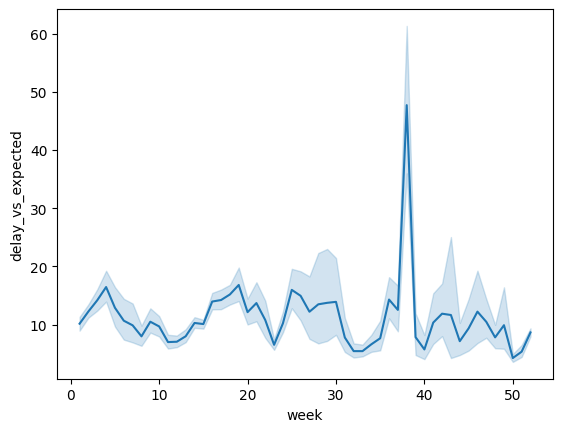

In [150]:
sns.lineplot(data=week_late_orders, x='week', y='delay_vs_expected')

📈 Plot the `number of delays` and `percentage of delayed orders` per week

In [158]:
#  number of delays: count of week_late_orders grouped by week
no_of_delays_weekly = week_late_orders.groupby('week')['order_id'].count()
#  weekly orders inc the ones that arrived on time
no_of_orders_weekly = data['orders'].groupby('week')['order_id'].count()
percentage_of_delayed_orders_weekly = (no_of_delays_weekly/no_of_orders_weekly*100).round()


In [173]:
# no_of_delays_weekly.values

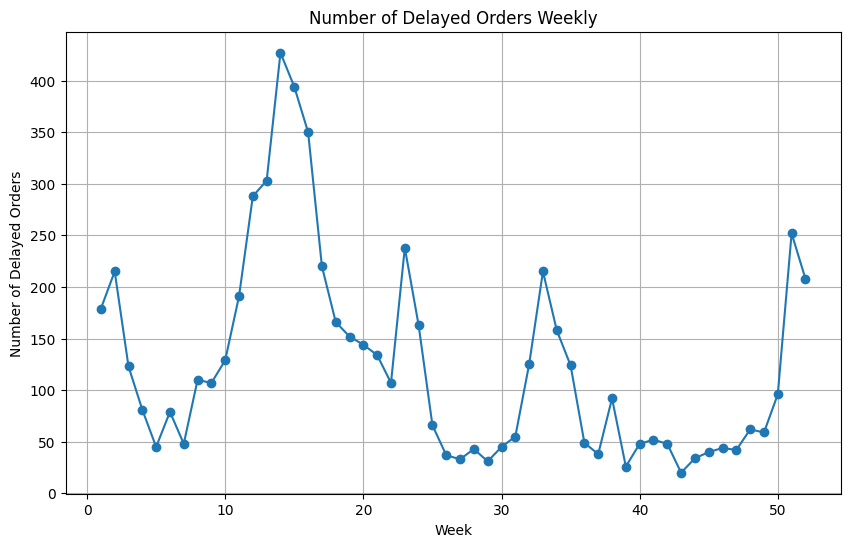

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(no_of_delays_weekly.index, no_of_delays_weekly.values, marker='o', linestyle='-')
plt.title('Number of Delayed Orders Weekly')
plt.xlabel('Week')
plt.ylabel('Number of Delayed Orders')
plt.grid(True)
plt.show()

#### Delay Analysis

📈 📉 From the previous graph, Olist experienced major lateness issues on 3-4 weeks ⚠️...

👉 Let's deep dive into these peaks of lateness.

❓ Create a dataframe (with weeks as indexes ) with the following columns:
* number of delays
* number of orders
* percentage of delayed orders

In [181]:

delays_df = pd.DataFrame({
    'no_of_orders_weekly':no_of_orders_weekly ,
    'no_of_delays_weekly': no_of_delays_weekly,
    'percentage_of_delayed_orders_weekly': percentage_of_delayed_orders_weekly},
index=percentage_of_delayed_orders_weekly.index)

# delays_df

❓ Create sub-dataframes to seperate these weeks into subgroups.

A suggestion:
- 20% and more
- 15-20%
- 10-15%
- 5-10%
- 5% and less

In [194]:
less_than_5pcnt_delays = delays_df[delays_df['percentage_of_delayed_orders_weekly']<5]
five_to_10pcnt_delays = delays_df[(delays_df['percentage_of_delayed_orders_weekly']>5) & (delays_df['percentage_of_delayed_orders_weekly']<=10)]
ten_to_15pcnt_delays = delays_df[(delays_df['percentage_of_delayed_orders_weekly']>10) & (delays_df['percentage_of_delayed_orders_weekly']<=15)]
fifteen_to_20pcnt_delays = delays_df[(delays_df['percentage_of_delayed_orders_weekly']>15) & (delays_df['percentage_of_delayed_orders_weekly']<=20)]
more_than_20pcnt_delays = delays_df[delays_df['percentage_of_delayed_orders_weekly']>20]

In [195]:
# five_to_10pcnt_delays